# 📂 Notebook 02 – Outils et Visualisations DR5

Ce notebook regroupe des outils pratiques pour analyser, visualiser et affiner les spectres téléchargés. Il permet d’explorer facilement tes données sans avoir à relancer le pipeline complet.

Utilise ces outils pour :
- Vérifier le contenu des fichiers FITS (headers, métadonnées, etc.).
- Affiner la détection des raies spectrales avant d’entraîner ton modèle.
- Débugger rapidement des spectres problématiques.

<br/>

In [1]:
# Cellule 1 : SETUP et Import des Outils
import os
import sys

# Ajout du chemin vers 'src' pour trouver nos modules
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import de notre outil de setup et de notre outil de visualisation
from utils import setup_project_env
from tools.visualizer import AstroVisualizer

# On importe les outils d'affichage dont on a besoin dans le notebook
from IPython.display import display, Markdown

# Initialisation
paths = setup_project_env()
visualizer = AstroVisualizer(paths)

print("\n Setup terminé. Outils prêts à l'emploi.")

[INFO] Racine du projet détectée : c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git
[INFO] Dossier 'src' ajouté au sys.path.

 Setup terminé. Outils prêts à l'emploi.


#

##  Analyse du Header d’un Fichier FITS 

Cette cellule permet d’ouvrir un fichier FITS compressé ``.fits.gz`` et d’afficher son en-tête sous forme organisée et lisible, directement dans le notebook.

Elle t’aidera à :

- Vérifier rapidement la qualité des métadonnées (date, télescope, type d’objet, magnitudes, etc.).
- Identifier les informations clés (coordonnées, type de cible, plan d’observation, etc.).
- Détecter des incohérences ou des valeurs suspectes avant de lancer des traitements de masse.

**✨ Fonctionnalités principales**

Le script lit le header complet et le divise en sections thématiques :
- Informations générales : format, dimensions, etc.
- Métadonnées du fichier : date, auteur, origine.
- Paramètres du télescope : site, caméra, focus.
- Paramètres d’observation : dates, plan, identifiants.
- Position de l’objet : coordonnées célestes.
- Désignation et type de l’objet : ID, type, source.
- Magnitudes : valeurs mesurées sur plusieurs filtres.
- Type d’observation : cible, système de coordonnées.
- Expositions : temps d’expo, nombre d’expos, etc.

Chaque section affiche ses paramètres de façon lisible et alignée pour un débogage efficace.

Utilise le module ``astropy.io.fits`` pour une compatibilité parfaite avec les standards FITS.

In [3]:
display(Markdown("## Explorateur de Header FITS"))
display(Markdown("Utilisez le menu déroulant pour sélectionner un spectre et afficher ses métadonnées complètes."))
visualizer.interactive_header_explorer()

## Explorateur de Header FITS

Utilisez le menu déroulant pour sélectionner un spectre et afficher ses métadonnées complètes.

interactive(children=(Dropdown(description='fits_relative_path', options=('B6202/spec-55862-B6202_sp01-001.fit…

#

## 🛠️ Tuning interactif

Cette cellule introduit une interface interactive pour ajuster visuellement deux hyperparamètres essentiels au traitement des spectres :
> la ``prominence`` et la ``fenêtre`` de détection des raies spectrales.

L’objectif est de permettre à l’utilisateur (ou à un chercheur) de tester dynamiquement l’impact de différents réglages sur les spectres, sans avoir à modifier manuellement le code à chaque fois. C’est une étape précieuse dans la validation empirique des paramètres avant l’extraction en masse sur tout le dataset.

### ⚙️ Ce que cette cellule met en place :

1. Préparation de l’environnement Python :

    - Import des bibliothèques utiles (``ipywidgets``, ``matplotlib``, ``astropy``, etc.).
    - Ajout dynamique du dossier ``src`` au ``sys.path`` pour pouvoir utiliser tes classes personnalisées (``SpectraPreprocessor``, ``PeakDetector``).

2. Chargement du pipeline de traitement :

    - Une instance de ``SpectraPreprocessor`` est créée pour normaliser, nettoyer et interpoler les spectres.
    -Un détecteur de pics (``PeakDetector``) sera aussi utilisé plus loin pour la détection des raies.

3. Création des sliders interactifs avec ``ipywidgets`` :

    - ``slider_prominence`` : contrôle le seuil minimal de proéminence d’un pic (entre 0.05 et 2.0).
    - ``slider_window`` : ajuste la largeur de la fenêtre de détection (entre 1 et 50 pixels).
    - Ces sliders seront liés à une fonction interactive de visualisation.

4. But final (à compléter dans la cellule suivante) :

    - Une fonction sera connectée à ces widgets pour afficher en direct les raies détectées sur un spectre exemple.
    - Tu pourras ajuster les paramètres en temps réel pour observer leur impact.

### 🧠 Intérêt

Ce genre de tuning interactif est très utile pour :

- **Trouver un compromis optimal** entre sensibilité et bruit dans la détection.
- **Comparer visuellement des stratégies d’extraction** avant de traiter des milliers de spectres automatiquement.
- **Améliorer l’intuition** des utilisateurs ou étudiants sur les paramètres liés à l’analyse spectrale.

#

In [4]:
display(Markdown("--- \n## Analyseur de Spectre Augmenté"))
display(Markdown(
    "Cet outil tout-en-un vous permet de visualiser un spectre, d'ajuster les "
    "paramètres de détection de pics en temps réel, et d'évaluer la qualité "
    "des données et de l'analyse."
))

# Cet appel unique crée maintenant l'interface complète
visualizer.interactive_spectrum_analyzer()

--- 
## Analyseur de Spectre Augmenté

Cet outil tout-en-un vous permet de visualiser un spectre, d'ajuster les paramètres de détection de pics en temps réel, et d'évaluer la qualité des données et de l'analyse.

interactive(children=(Dropdown(description='Spectre :', layout=Layout(width='max-content'), options=('B6202/sp…

#

## 🔍 Analyse des valeurs nulles dans les features

Cette cellule permet d’inspecter la qualité des données en analysant le pourcentage de zéros dans chaque colonne de features. Cela est essentiel pour :

- Identifier les features peu informatives ou inutilisables,
- Évaluer le taux de remplissage des données,
- Prendre des décisions de nettoyage ou d’exclusion avant l'entraînement du modèle.

### ✨ Étapes réalisées dans ce bloc :

1. Chargement du fichier CSV contenant les features extraites, généré précédemment à partir des spectres :

```python
csv_path = "../data/processed/features_*.csv"
```

2. Sélection des colonnes pertinentes, c’est-à-dire celles qui commencent par "feature_". Cela exclut les colonnes comme "label" ou "file_path".

3. Calcul du pourcentage de valeurs nulles (ici considérées comme 0.0) pour chaque feature :

    - Pour chaque colonne, on compte les zéros et on divise par la taille totale.
    - Un dictionnaire ``zero_stats`` est construit, mappant chaque feature à son pourcentage de zéros.

4. Conversion en DataFrame trié par importance décroissante du pourcentage de zéros.

5. Visualisation des résultats sous forme de graphique à barres :

    - Chaque barre représente une feature.
    - Une ligne rouge est ajoutée à 90 % comme seuil d’alerte au-delà duquel une feature pourrait être jugée non pertinente.

### 🧠 Intérêt

Cette étape joue un rôle critique dans la sélection des features :
> elle permet de repérer des features systématiquement nulles (ex. : raies non détectées) ou trop peu présentes dans le jeu de données, ce qui peut biaiser ou nuire à l’apprentissage automatique.

--- 
## Analyse de la Qualité des Features

Cet outil analyse le dernier fichier de features généré et montre le pourcentage de valeurs nulles pour chaque feature. C'est essentiel pour identifier les features peu informatives.

--- Analyse des Valeurs Nulles (Zéros) dans les Features ---
  > Analyse du fichier : features_20250722T235845Z.csv


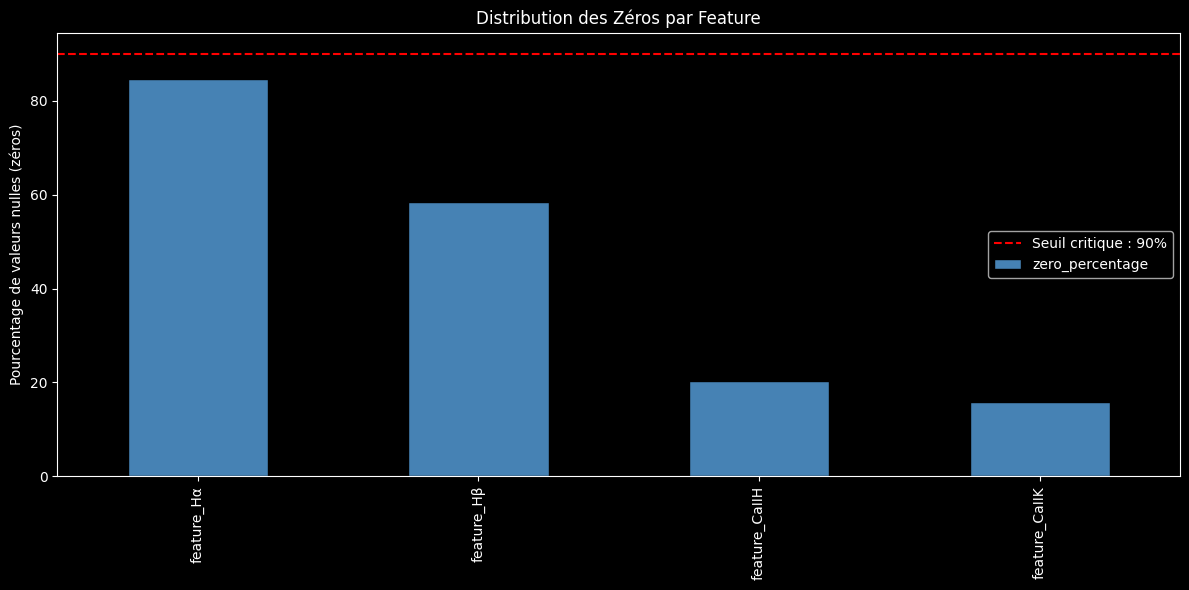

In [4]:
display(Markdown("--- \n## Analyse de la Qualité des Features"))
display(Markdown("Cet outil analyse le dernier fichier de features généré et montre le pourcentage de valeurs nulles pour chaque feature. C'est essentiel pour identifier les features peu informatives."))
visualizer.analyze_feature_zeros()

#

## Carte de Couverture Céleste

--- 
## Carte de Couverture Céleste

Cette carte montre la position des plans d'observation que tu as téléchargés. La taille et la couleur des points indiquent le nombre de spectres par plan.

--- Carte de Couverture Céleste ---
  > Scan des fichiers FITS pour générer le catalogue de position...


Lecture des headers:   0%|          | 0/9550 [00:00<?, ?it/s]


  > Catalogue de position créé avec 6 plans uniques.


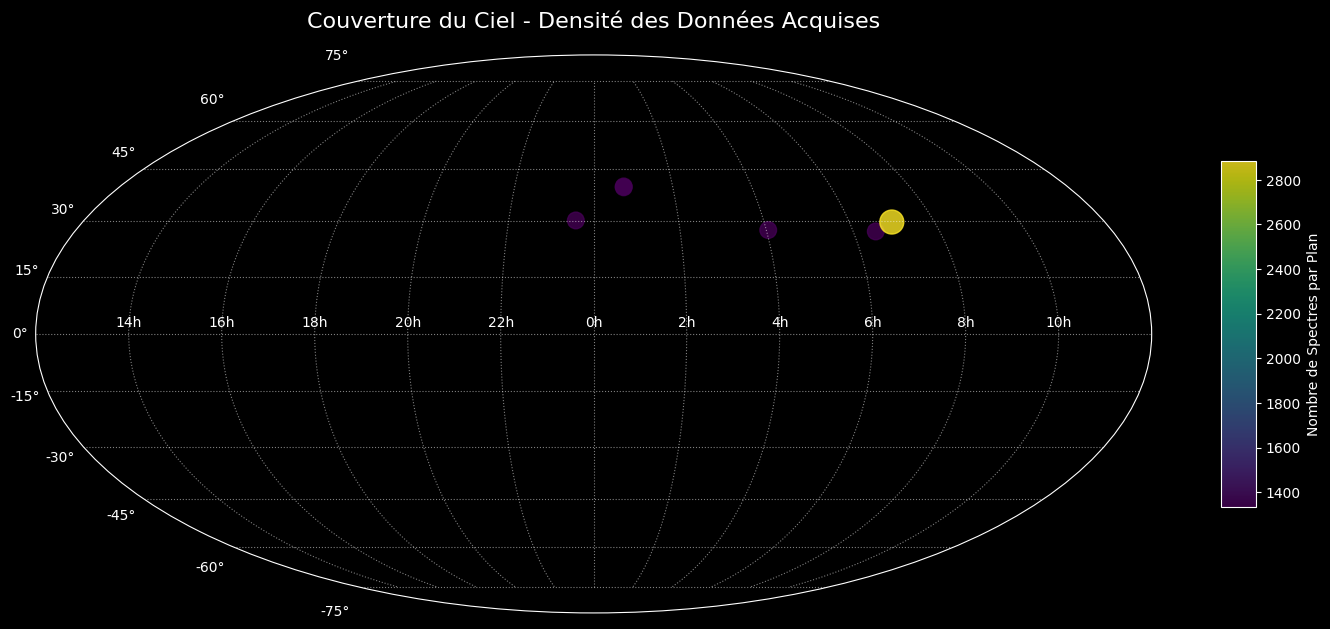

In [6]:
display(Markdown("--- \n## Carte de Couverture Céleste"))
display(Markdown("Cette carte montre la position des plans d'observation que tu as téléchargés. La taille et la couleur des points indiquent le nombre de spectres par plan."))
visualizer.plot_sky_coverage()

#

# Inspecteur de Modèles Entraînés

In [3]:
display(Markdown("--- \n## Inspecteur de Modèles Entraînés"))
display(Markdown(
    "Utilisez le menu déroulant pour sélectionner un modèle `.pkl` sauvegardé. "
    "Cet outil affichera ses hyperparamètres et un graphique montrant l'importance de chaque feature "
    "pour la classification."
))

# Cet appel unique crée l'interface d'inspection
visualizer.interactive_model_inspector()

--- 
## Inspecteur de Modèles Entraînés

Utilisez le menu déroulant pour sélectionner un modèle `.pkl` sauvegardé. Cet outil affichera ses hyperparamètres et un graphique montrant l'importance de chaque feature pour la classification.

interactive(children=(Dropdown(description='model_path', options=('c:\\Users\\alexb\\Documents\\Google_Cloud\\…